## IMPORTS :

In [73]:
import os
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

## Récupération du corpus
(pour qu'on puisse l'utiliser avec sklearn)

In [54]:
dossier_train = "../../deft09/corpus_train"
dossier_test = "../../deft09/corpus_test"
dossier_ref = "../../deft09/donnees_ref"

In [55]:
def recup_train_data(dossier) : 
    """
    extraction du texte et des étiquettes des documents XML d'un répertoire.
    """
    train_textes = []
    labels_train = []
    for fichier in os.listdir(dossier) : 
        if fichier.endswith(".xml"):
            chemin_fichier = os.path.join(dossier, fichier)
            tree = ET.parse(chemin_fichier) #analyse et parsing du fichier
            root = tree.getroot() #obtient l'élément racine de l'arbre XML (le noeud principal de l'arbre)

            for doc in root.findall("doc") : 
                intervention = doc.find(".//texte/p")
                if intervention is not None and intervention.text is not None : 
                 texte = intervention.text
                else : 
                    texte = ""
                parti = doc.find(".//EVALUATION/EVAL_PARTI/PARTI")
                if parti is not None and "valeur" in parti.attrib : 
                    label = parti.get("valeur")
                else : 
                    label = "Unknown"

                train_textes.append(texte)
                labels_train.append(label)
                
    print(f"Nb textes train : {len(train_textes)}")
    print(f"Nb labels train : {len(labels_train)}")

    return train_textes, labels_train

def recup_test_data(dossier) : 
    test_textes = []
    for fichier in os.listdir(dossier) : 
        if fichier.endswith(".xml"):
            chemin_fichier = os.path.join(dossier, fichier)

            tree = ET.parse(chemin_fichier) #analyse et parsing du fichier
            root = tree.getroot() #obtient l'élément racine de l'arbre XML (le noeud principal de l'arbre)

            for doc in root.findall('doc'):
                texte_complet = ""
                for p in doc.find('texte').findall('p'):
                    if p.text : 
                        texte_complet += p.text.strip() + " "
                test_textes.append(texte_complet.strip())

    print(f"Nb textes test : {len(test_textes)}")
  
    return test_textes
    
def recup_donnees_ref(dossier) :
    labels_test = []
    for fichier in os.listdir(dossier) : 
        if fichier.endswith(".txt"):
            chemin_fichier = os.path.join(dossier, fichier)

            with open(chemin_fichier, "r", encoding="latin1") as file : 
                for ligne in file : 
                    ligne = ligne.strip()
                    ligne = ligne.replace("\t", " ")
                    parties = ligne.split()
                    if len(parties) > 1: 
                        labels_test.append(parties[1])
                    else:
                        print(f"Ligne ignorée : {ligne} sur le fichier {fichier}")
                        labels_test.append("Unknown")

    print(f"Nb labels test : {len(labels_test)}")
    
    return labels_test

In [56]:
textes_train, y_train = recup_train_data(dossier_train)

Nb textes train : 19370
Nb labels train : 19370


In [57]:
textes_test = recup_test_data(dossier_test)
y_test = recup_donnees_ref(dossier_ref)

Nb textes test : 12917
Ligne ignorée : 1175 sur le fichier deft09_parlement_ref_fr_utf8.txt
Ligne ignorée : 4574 sur le fichier deft09_parlement_ref_fr_utf8.txt
Nb labels test : 12917


**Vectorisation TFIDF** (+enlever les stopwords)

In [58]:
stopwords_list = stopwords.words("french") 

In [66]:
tfidf = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1,2))
X_train = tfidf.fit_transform(textes_train)
X_test = tfidf.transform(textes_test)

## KNeighbors Classifier

In [67]:
param_gridKNN = {
    "n_neighbors" : [1, 2, 10, 15],
    "weights" : ["uniform", "distance"], 
}

#Initialisation
KNN = KNeighborsClassifier()
KNN_grid = GridSearchCV(KNN, param_gridKNN, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
KNN_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", KNN_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_KNN = KNN_grid.best_estimator_
y_pred_best_KNN = best_KNN.predict(X_test)

#Résultats
print("Rapport de Classification KNeighbors Classifier:\n")
print(classification_report(y_test, y_pred_best_KNN))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[CV] END .....................n_neighbors=1, weights=uniform; total time=  19.1s
[CV] END .....................n_neighbors=1, weights=uniform; total time=  19.1s
[CV] END .....................n_neighbors=1, weights=uniform; total time=  19.1s
[CV] END .....................n_neighbors=1, weights=uniform; total time=  19.2s
[CV] END .....................n_neighbors=1, weights=uniform; total time=  13.7s
[CV] END ....................n_neighbors=1, weights=distance; total time=  13.7s
[CV] END ....................n_neighbors=1, weights=distance; total time=  13.8s
[CV] END ....................n_neighbors=1, weights=distance; total time=  13.9s
[CV] END ....................n_neighbors=1, weights=distance; total time=  13.6s
[CV] END .....................n_neighbors=2, weights=uniform; total time=  13.9s
[CV] END .....................n_neighbors=2, weights=uniform; total time=  13.9s
[CV] END ....................n_neighbors=1, weights=distance; total time=  14.1s
[CV] END ...................

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

## Multinomial Naive Bayes

In [68]:
param_gridMultiNB = {
    "alpha": [0.05, 0.2, 0.7, 1.0, 2],
    "fit_prior": [True, False]
}

#Initialisation
MultiNB = MultinomialNB()
MultiNB_grid = GridSearchCV(MultiNB, param_gridMultiNB, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
MultiNB_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", MultiNB_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_MultiNB = MultiNB_grid.best_estimator_
y_pred_best_MultiNB = best_MultiNB.predict(X_test)

#Résultats
print("Rapport de Classification Multinomial Naive Bayes:\n")
print(classification_report(y_test, y_pred_best_MultiNB))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.5s
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.6s
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.5s
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.6s
[CV] END .........................alpha=0.05, fit_prior=True; total time=   0.7s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.7s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.8s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.7s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.5s
[CV] END ........................alpha=0.05, fit_prior=False; total time=   0.5s
[CV] END ..........................alpha=0.2, fit_prior=True; total time=   0.5s
[CV] END ..........................alpha=0.2, fi

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

## Complement Naive Bayes

In [69]:
param_gridComplNB = {
    "alpha": [0.05, 0.2, 0.7, 1.0, 2],
    "fit_prior": [True, False],
    "norm": [True, False]
}

#Initialisation
ComplNB = ComplementNB()
ComplNB_grid = GridSearchCV(ComplNB, param_gridComplNB, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
ComplNB_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", ComplNB_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_ComplNB = ComplNB_grid.best_estimator_
y_pred_best_ComplNB = best_ComplNB.predict(X_test)

#Résultats
print("Rapport de Classification Complement Naive Bayes :\n")
print(classification_report(y_test, y_pred_best_ComplNB))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.7s
[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.7s
[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.7s
[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.7s
[CV] END ..............alpha=0.05, fit_prior=True, norm=True; total time=   0.8s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   0.8s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   0.8s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   0.8s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   1.1s
[CV] END .............alpha=0.05, fit_prior=False, norm=True; total time=   1.1s
[CV] END .............alpha=0.05, fit_prior=True, norm=False; total time=   1.1s
[CV] END .............alpha=0.05, fit_prior=False, norm=True; total time=   1.1s
[CV] END .............alpha=

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

## SVM

In [70]:
param_gridSVM = { 
    "C" : [0.2, 1, 10],
    "dual": [True, False],
    "class_weight" : ["balanced", None],
    "max_iter" : [700, 1000]
}

#Initialisation
svm = LinearSVC()
svm_grid = GridSearchCV(svm, param_gridSVM, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
svm_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", svm_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_svm = svm_grid.best_estimator_
y_pred_best_svm = best_svm.predict(X_test)

#Résultats
print("Rapport de Classification SVM :\n")
print(classification_report(y_test, y_pred_best_svm))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   5.8s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   5.9s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   5.8s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   5.9s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=700; total time=   6.3s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   6.3s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   6.4s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   6.4s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   5.5s
[CV] END C=0.2, class_weight=balanced, dual=True, max_iter=1000; total time=   5.7s
[CV] END C=0.2, class_weight=balanced, dual=False, max_iter=700; total time=  23.5s
[CV] END C=0.2, cla

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.4min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.4min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.2min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.3min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=700; total time= 2.2min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 2.4min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 2.1min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 2.5min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.7min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.7min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 2.6min
[CV] END C=10, class_weight=balanced, dual=True, max_iter=1000; total time= 2.9min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.5min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.7min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=700; total time= 1.5min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.8min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.8min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.6min
[CV] END C=10, class_weight=balanced, dual=False, max_iter=1000; total time= 1.7min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 2.0min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 2.0min
[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 1.8min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 2.0min


/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...C=10, class_weight=None, dual=True, max_iter=700; total time= 2.0min
[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 2.0min
[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 1.9min
[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 1.7min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.4min
[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 2.1min
[CV] END ..C=10, class_weight=None, dual=True, max_iter=1000; total time= 2.1min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.4min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.6min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.7min
[CV] END .C=10, class_weight=None, dual=False, max_iter=1000; total time= 1.6min
[CV] END ..C=10, class_weight=None, dual=False, max_iter=700; total time= 1.8min
[CV] END .C=10, class_weight

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

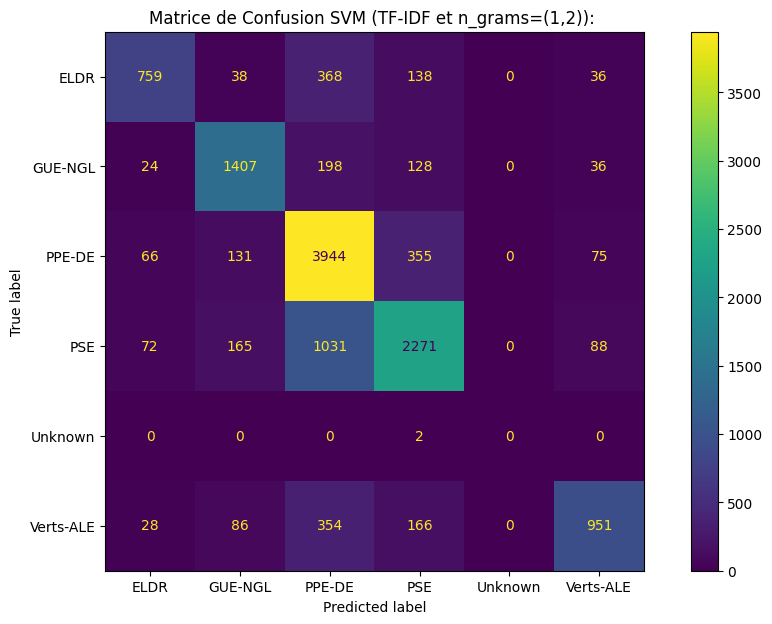

In [79]:
etiquettes = ["ELDR", "GUE-NGL", "PPE-DE", "PSE", "Unknown", "Verts-ALE"]

matrice = confusion_matrix(y_test, y_pred_best_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=matrice, display_labels=etiquettes)

plt.figure(figsize = (12, 7))
disp.plot(ax=plt.gca())
plt.title("Matrice de Confusion SVM (TF-IDF et n_grams=(1,2)): ")
plt.show()

## Logistic Regression 

In [71]:
param_gridLR = { 
    "C" : [0.2, 1, 10],
    "class_weight" : ["balanced", None],
    "max_iter" : [1000, 2000]
}

#Initialisation
LR = LogisticRegression()
LR_grid = GridSearchCV(LR, param_gridLR, cv=5, verbose=2, n_jobs=-1)

#Entraînement du modèle
LR_grid.fit(X_train, y_train)

#Afficher les meilleurs paramètres
print("Meilleurs paramètres : ", LR_grid.best_params_)

#Prédiction avec les meilleurs paramètres obtenus
best_LR = LR_grid.best_estimator_
y_pred_best_LR = best_LR.predict(X_test)

#Résultats
print("Rapport de Classification Logistic Regression :\n")
print(classification_report(y_test, y_pred_best_LR))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time= 1.1min
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time= 1.1min
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time= 1.1min
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time= 1.2min
[CV] END ........C=0.2, class_weight=balanced, max_iter=1000; total time=  45.1s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=  46.2s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=  49.3s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=  49.6s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=  46.3s
[CV] END ........C=0.2, class_weight=balanced, max_iter=2000; total time=  56.9s
[CV] END ............C=0.2, class_weight=None, max_iter=1000; total time=  42.6s
[CV] END ............C=0.2, class_weight=None, m

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

## Random Forest

In [51]:
# param_gridRF = {
#     "n_estimators" : [50, 100, 150], 
#     "max_depth" : [100, 250, 300], 
#     "min_samples_split" : [2, 5], 
# }

# #Initialisation
# RF = RandomForestClassifier(random_state=42)
# RF_grid = GridSearchCV(RF, param_gridRF, cv=5, verbose=2, n_jobs=-1)

# #Entraînement du modèle
# RF_grid.fit(X_train, y_train)

# #Afficher les meilleurs paramètres
# print("Meilleurs paramètres : ", RF_grid.best_params_)

# #Prédiction avec les meilleurs paramètres obtenus
# best_RF = RF_grid.best_estimator_
# y_pred_best_RF = best_RF.predict(X_test)

# #Résultats
# print("Rapport de Classification Random Forest :\n")
# print(classification_report(y_test, y_pred_best_RF))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 2.6min
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 2.6min
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 2.6min
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 2.6min
[CV] END max_depth=100, min_samples_split=2, n_estimators=50; total time= 2.6min
[CV] END max_depth=100, min_samples_split=2, n_estimators=100; total time= 5.8min
[CV] END max_depth=100, min_samples_split=2, n_estimators=100; total time= 5.9min
[CV] END max_depth=100, min_samples_split=2, n_estimators=100; total time= 5.9min
[CV] END max_depth=100, min_samples_split=2, n_estimators=100; total time= 7.0min
[CV] END max_depth=100, min_samples_split=2, n_estimators=100; total time= 7.1min
[CV] END max_depth=100, min_samples_split=2, n_estimators=150; total time=10.3min
[CV] END max_depth=100, min_samples_split=

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Meilleurs paramètres :  {'max_depth': 300, 'min_samples_split': 5, 'n_estimators': 150}
Rapport de Classification Random Forest :



/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        ELDR       0.36      0.05      0.09      4017
     GUE-NGL       0.28      0.30      0.29      5379
      PPE-DE       0.39      0.75      0.51     13713
         PSE       0.39      0.20      0.26     10881
     Unknown       0.00      0.00      0.00         6
   Verts-ALE       0.41      0.05      0.09      4755

    accuracy                           0.37     38751
   macro avg       0.31      0.22      0.21     38751
weighted avg       0.37      0.37      0.32     38751



/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## COMPARAISON DES PERFORMANCES DES MODÈLES

In [72]:
resultats = pd.DataFrame({
    "Modèle": ["KNeighbors", "Multinomial Naive Bayes", "Complement Naive Bayes", "SVM", "Logistic Regression"],
    "Accuracy" : 
        [accuracy_score(y_test, y_pred_best_KNN),
        accuracy_score(y_test, y_pred_best_MultiNB),
        accuracy_score(y_test, y_pred_best_ComplNB),
        accuracy_score(y_test, y_pred_best_svm),
        accuracy_score(y_test, y_pred_best_LR)],
    "Précision": 
        [precision_score(y_test, y_pred_best_KNN, average="weighted"),
        precision_score(y_test, y_pred_best_MultiNB, average="weighted"),
        precision_score(y_test, y_pred_best_ComplNB, average="weighted"),
        precision_score(y_test, y_pred_best_svm, average="weighted"),
        precision_score(y_test, y_pred_best_LR, average="weighted")],
    "Rappel" : 
        [recall_score(y_test, y_pred_best_KNN, average="weighted"),
        recall_score(y_test, y_pred_best_MultiNB, average="weighted"),
        recall_score(y_test, y_pred_best_ComplNB, average="weighted"),
        recall_score(y_test, y_pred_best_svm, average="weighted"),
        recall_score(y_test, y_pred_best_LR, average="weighted")],
    "F-mesure" : 
        [f1_score(y_test, y_pred_best_KNN, average="weighted"),
        f1_score(y_test, y_pred_best_MultiNB, average="weighted"),
        f1_score(y_test, y_pred_best_ComplNB, average="weighted"),
        f1_score(y_test, y_pred_best_svm, average="weighted"),
        f1_score(y_test, y_pred_best_LR, average="weighted")]
})

print(resultats)

/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/manongourves/envs/app_auto/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

                    Modèle  Accuracy  Précision    Rappel  F-mesure
0               KNeighbors  0.343423   0.802203  0.343423  0.244658
1  Multinomial Naive Bayes  0.676008   0.776424  0.676008  0.662563
2   Complement Naive Bayes  0.662305   0.793927  0.662305  0.652196
3                      SVM  0.722459   0.733349  0.722459  0.718334
4      Logistic Regression  0.704421   0.719379  0.704421  0.699318
